# Analysis and Prediction

For this section first we will make a prediction by using timer series analysis. After that we will use the machine learning model to predict whether is it safe to ride an airplane. Most of the analysis here will use time as their time constraint since our features in the data is quite messy. More time is needed to r

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set(style="white")

In [2]:
df = pd.read_pickle('../aircrash-analysis.pkl')
df_summary = pd.read_pickle('../Summary_token_word.pkl')

In [130]:
df_corr = df[['Aboard','Fatalities','Ground']]

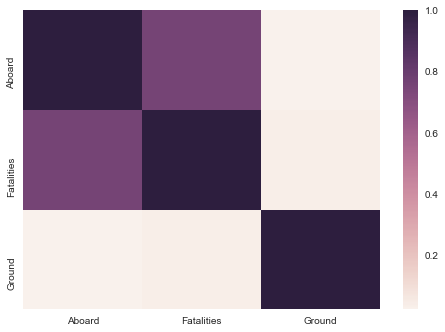

In [131]:
sns.heatmap(df_corr.corr())

As shown before the number of fatalities and abord are linearly correlated to each other. For ground itself it is quite random and unrelated to the fatalities and aboard.

## Time Series Analysis (Yearly)

### Fatalities 

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [4]:
ts = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))
X = np.arange(1908,2010).reshape(-1,1)

In [5]:
# Calculating the sum for each year
for year in range(1908,2010):
    ts['{}'.format(year)] = len(df['{}'.format(year)])

y = ts.values

In [6]:
LR = LinearRegression()
LR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

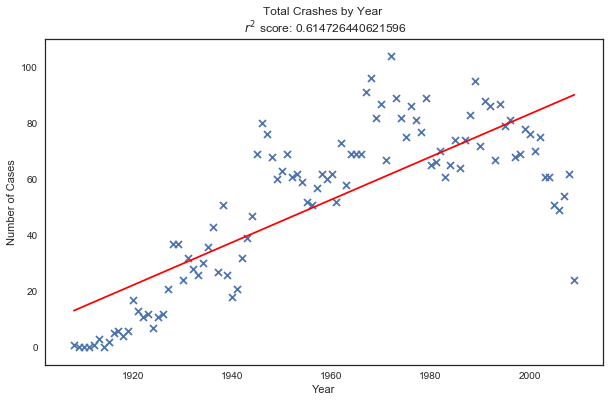

In [7]:
plt.figure(figsize=(10,6))
plt.plot(X,LR.predict(X),color='r')
plt.scatter(X,y,marker='x')
plt.title('Total Crashes by Year \n $r^2$ score: {}'.format(r2_score(y,LR.predict(X))))
plt.xlabel('Year')
plt.ylabel('Number of Cases')

In [8]:
svr = SVR(C=1e2,gamma=0.001)
svr.fit(X,y)

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

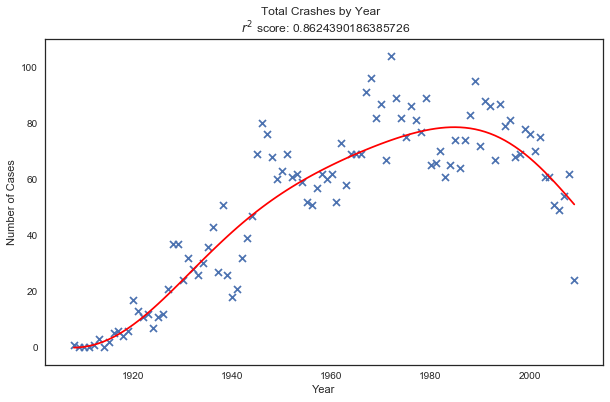

In [9]:
plt.figure(figsize=(10,6))
plt.plot(X,svr.predict(X),color='r')
plt.scatter(X,y,marker='x')
plt.title('Total Crashes by Year  \n $r^2$ score: {}'.format(r2_score(y,svr.predict(X))))
plt.xlabel('Year')
plt.ylabel('Number of Cases')

In [10]:
ts = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))

In [11]:
# Calculating the fatalities for each year
for year in range(1908,2010):
    ts['{}'.format(year)] = df['{}'.format(year)].Fatalities.sum()

In [12]:
y = ts.values

In [13]:
LR = LinearRegression()
LR.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

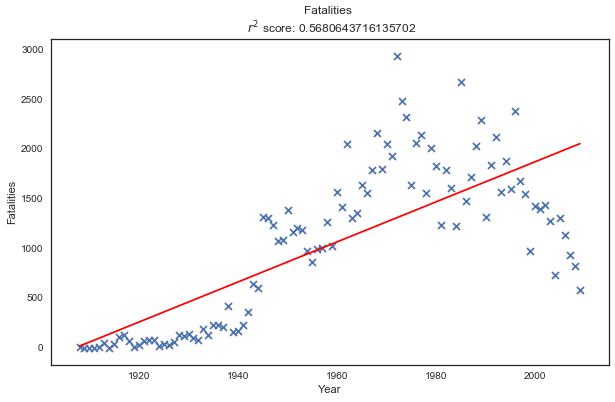

In [14]:
plt.figure(figsize=(10,6))
plt.plot(X,LR.predict(X),color='r')
plt.scatter(X,y,marker='x')
plt.title('Fatalities \n $r^2$ score: {}'.format(r2_score(y,LR.predict(X))))
plt.xlabel('Year')
plt.ylabel('Fatalities')

In [15]:
svr = SVR(C=1e3,gamma=0.001)
svr.fit(X,y)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

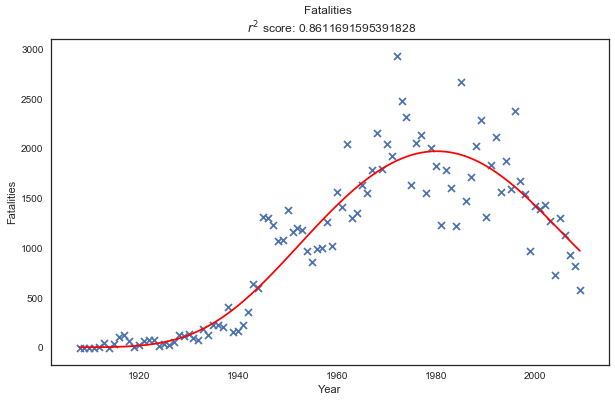

In [16]:
plt.figure(figsize=(10,6))
plt.plot(X,svr.predict(X),color='r')
plt.scatter(X,y,marker='x')
plt.title('Fatalities \n $r^2$ score: {}'.format(r2_score(y,svr.predict(X))))
plt.xlabel('Year')
plt.ylabel('Fatalities')

## ARIMA Model (Auto Regressive Integrated Moving Average)

We will try to predict the projection of the number of fatalities and cases for the next 5 years after 2008 to see whether is it safer to take an aircraft nowadays. To use ARIMA mode we need to ensure that our time series data is at stationary (No trend). This can be done by using adfuller test to check the stationarity of the graph. For our prediction model we only include the __PASSENGER AIR CRAFT__ only because that is most likely what we are going to ride.

# Fatalities Prediction

In [34]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [24]:
# Stationary Checkers function - To check whether the time series has no trend
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
ts = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))

In [20]:
df_Passenger = df[df.Passenger_Military == 1]

In [21]:
# Calculating the sum for each year
for year in range(1908,2010):
    ts['{}'.format(year)] = df_Passenger['{}'.format(year)].Fatalities.sum()

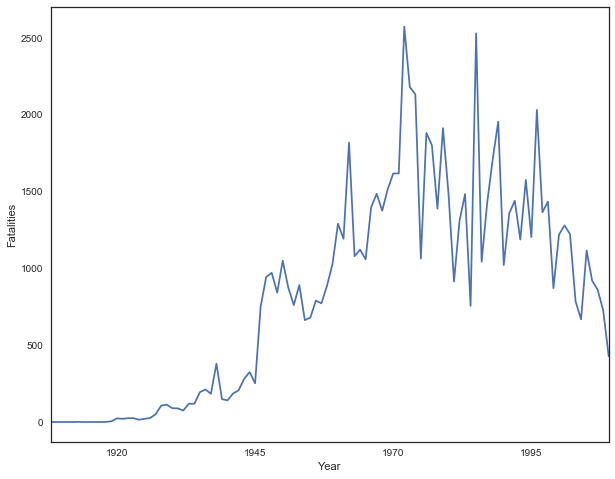

In [27]:
plt.figure(figsize=(10,8))
ts.plot()
plt.xlabel('Year')
plt.ylabel('Fatalities')

In [28]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.566868
p-value                         0.500212
#Lags Used                      2.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


The test statistics here show that it has more than the critical value of 10%. Hence it failed to reject the null hypothesis. We need to to make some modification to the graph for it to be stationary. 

In [29]:
ts_log = np.log(ts)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [32]:
ts_log.replace([-np.inf,np.inf],0,inplace=True)

In [33]:
test_stationarity(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                 -3.826243
p-value                         0.002650
#Lags Used                      5.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


Luckily for us by taking the log series we managed to get a test statistic less than 1%. We can conclude that the product of log for our time series is stationary with confidence level of 99%.

### Order of ARIMA

ARIMA model take 3 parameters $ARIMA(p,d,q)$. $p$ and $q$ is determine by the number of spikes at our PACF plot and ACF plot respectively. $d$ is the differencing of our time series. Since we didn't have to use any differencing so, $d=0$ for our cases.

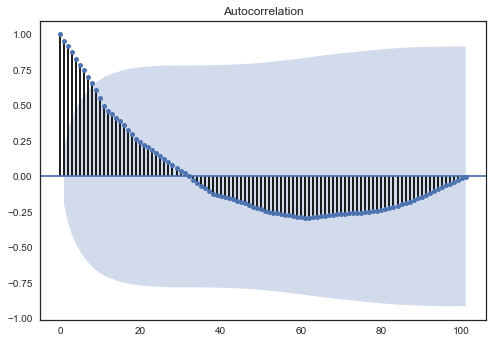

In [35]:
acf = plot_acf(ts_log)

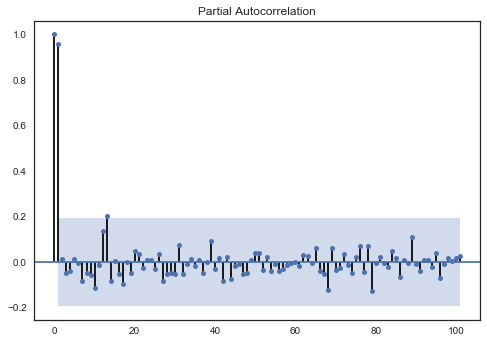

In [36]:
pacf = plot_pacf(ts_log)

As we can see for our ACF plot the graph show a decay while for our PACF plot show a spikes and there are two of them. Hence, our model here will be $ARIMA(2,0,0)$ or also known as $AR(2)$.

Let's split our time series data to train and test set to see how it behave. We take the consecutive 5 years as our test set.

In [37]:
ts_train = ts_log[:-5]
ts_test = ts_log[-5:]

In [42]:
model = ARIMA(ts_train,order=(2,0,0))
result_ARIMA = model.fit()

In [43]:
result_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:                     ARMA(2, 0)   Log Likelihood                 -55.357
Method:                       css-mle   S.D. of innovations              0.419
Date:                Wed, 20 Sep 2017   AIC                            118.714
Time:                        10:33:08   BIC                            129.013
Sample:                    01-01-1908   HQIC                           122.879
                         - 01-01-2004                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8567      2.773      1.391      0.168      -1.578       9.291
ar.L1.y        0.8865      0.101      8.810      0.000       0.689       1.084
ar.L2.y        0.1056      0.101      1.043      0.300      -0.093       0.304
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0073           +0.0000j            1.0073            0.0000
AR.2           -9.4052           +0.0000j            9.4052            0.5000
-----------------------------------------------------------------------------
"""

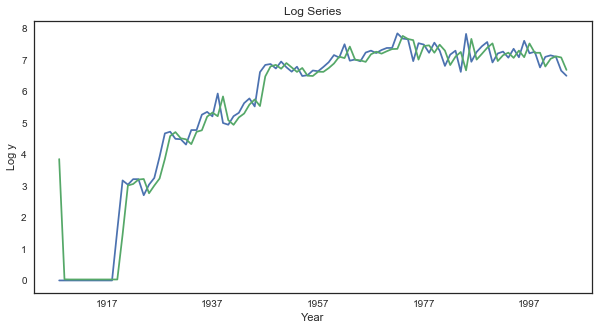

In [48]:
plt.figure(figsize=(10,5))
plt.plot(ts_train,label='True')
plt.plot(result_ARIMA.fittedvalues,label='Predicted')
plt.title('Log Series')
plt.xlabel('Year')
plt.ylabel('Log y')

In [49]:
forecast, stderror, conf_int = result_ARIMA.forecast(5,alpha=0.05)
forecast_, stderror_, conf_int_ = result_ARIMA.forecast(5,alpha=0.01)

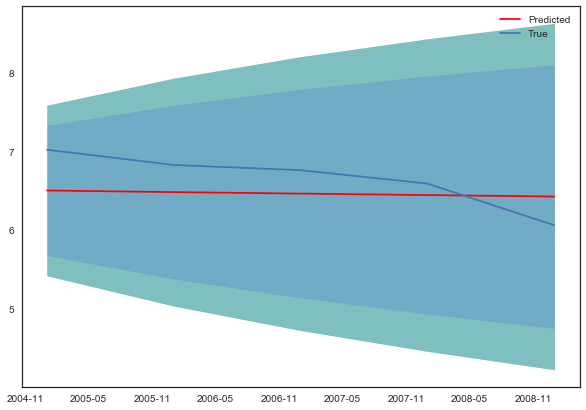

In [56]:
plt.figure(figsize=(10,7))
plt.plot(ts_test.index,forecast,color='r',label='Predicted')
plt.plot(ts_test,label='True')
plt.fill_between(ts_test.index, conf_int_[:,0], conf_int_[:,1], alpha=0.5, edgecolor='teal', facecolor='teal')
plt.fill_between(ts_test.index, conf_int[:,0], conf_int[:,1], alpha=0.1, edgecolor='b', facecolor='b')
plt.legend()

As we can see for the log value itself, ARIMA model do a quite good prediction. The blue and green filled is our confidence interval of 95% and 99% respectively. As we can see the True values still lies in the interval of 95% confidence interval. Let's take it to original scales.

In [60]:
forecast_exp = np.exp(forecast)

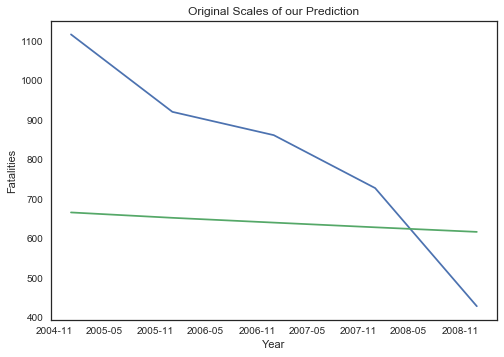

In [68]:
plt.plot(np.exp(ts_test))
plt.plot(ts_test.index,forecast_exp)
plt.title('Original Scales of our Prediction')
plt.xlabel('Year')
plt.ylabel('Fatalities')

# Number of Cases Prediction

In [69]:
ts = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))

In [70]:
# Calculating the sum for each year
for year in range(1908,2010):
    ts['{}'.format(year)] = len(df_Passenger['{}'.format(year)])

In [71]:
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -1.892887
p-value                         0.335414
#Lags Used                      2.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [72]:
ts_log = np.log(ts)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [73]:
ts_log.replace([-np.inf,np.inf],0,inplace=True)

In [75]:
test_stationarity(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                 -3.596430
p-value                         0.005830
#Lags Used                      5.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


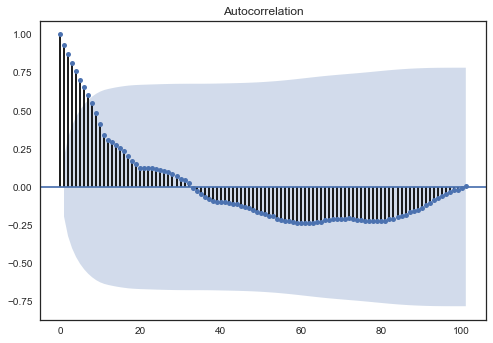

In [76]:
acf = plot_acf(ts_log)

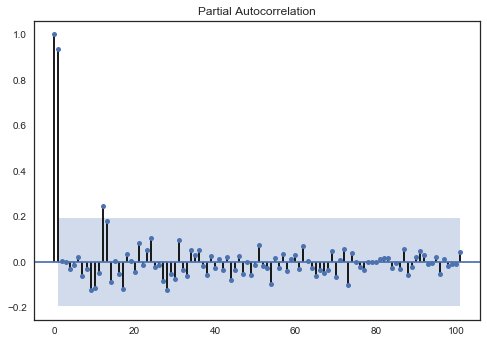

In [77]:
acf = plot_pacf(ts_log)

In [78]:
from statsmodels.tsa.ar_model import AR

In [103]:
ts_train = ts_log[:-5]
ts_test = ts_log[-5:]

In [119]:
model = ARIMA(ts_train,order=(2,0,0))
result_ARIMA = model.fit()

In [114]:
predict = result_AR.predict(start='2005',end='2009')

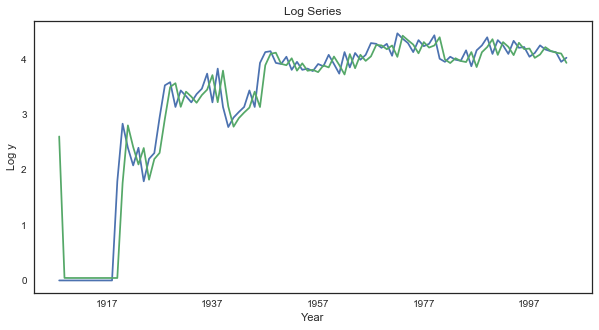

In [120]:
plt.figure(figsize=(10,5))
plt.plot(ts_train,label='True')
plt.plot(result_ARIMA.fittedvalues,label='Predicted')
plt.title('Log Series')
plt.xlabel('Year')
plt.ylabel('Log y')

In [121]:
forecast, stderror, conf_int = result_ARIMA.forecast(5,alpha=0.05)
forecast_, stderror_, conf_int_ = result_ARIMA.forecast(5,alpha=0.01)

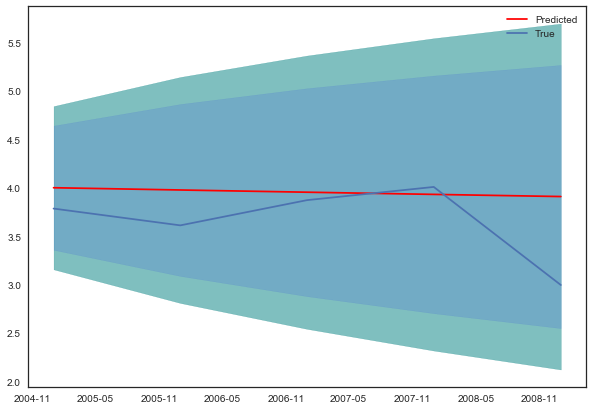

In [123]:
plt.figure(figsize=(10,7))
plt.plot(ts_test.index,forecast,color='r',label='Predicted')
plt.plot(ts_test,label='True')
plt.fill_between(ts_test.index, conf_int_[:,0], conf_int_[:,1], alpha=0.5, edgecolor='teal', facecolor='teal')
plt.fill_between(ts_test.index, conf_int[:,0], conf_int[:,1], alpha=0.1, edgecolor='b', facecolor='b')
plt.legend()

In [124]:
forecast_exp = np.exp(forecast)

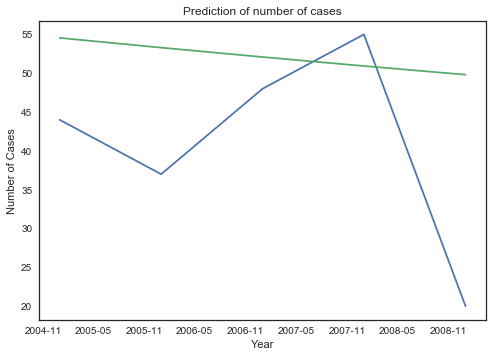

In [127]:
plt.plot(np.exp(ts_test))
plt.plot(ts_test.index,forecast_exp)
plt.title('Prediction of number of cases')
plt.xlabel('Year')
plt.ylabel('Number of Cases')

## Summary Result and Conclusion

From the ARIMA model above we can see that, ARIMA model is doing a good work at predicting the future the confidence interval for both number of fatalities and number of cases. But ARIMA model failed to predict pattern or trend of the time series. For the trend, Support Vector Regression using rbf kernel doing a good job at finding the line of best fit and we can see the downward trend with a $r^2$ score of 0.86. As a conclusion, the __downward trend__ of the __number of cases__ indicates that our __air craft safety__ is __increase__, hence it is __safe to ride an air craft__. 

### Machine Learning Model

In here we will remove the time factor and use the difference of one year for as our features to predict the number of cases.

In [147]:
ts_crash = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))
# Calculating the sum for each year
for year in range(1908,2010):
    ts_crash['{}'.format(year)] = len(df['{}'.format(year)])


In [148]:
ts_fatalities = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))
# Calculating the fatalities for each year
for year in range(1908,2010):
    ts_fatalities['{}'.format(year)] = df['{}'.format(year)].Fatalities.sum()

In [149]:
ts_aboard = pd.Series(np.nan,index=pd.date_range('1908','2009',freq='AS'))
# Calculating the fatalities for each year
for year in range(1908,2010):
    ts_aboard['{}'.format(year)] = df['{}'.format(year)].Aboard.sum()

In [151]:
df = pd.concat([ts_crash.to_frame(),ts_fatalities.to_frame(),ts_aboard.to_frame()],axis=1)

In [153]:
df_diff = df.diff().dropna()

In [166]:
df_diff.columns.values[0] = 1
df_diff.columns.values[1] = 2
df_diff.columns.values[2] = 3

In [167]:
from sklearn.model_selection import train_test_split

In [171]:
X = df_diff[[2,3]].as_matrix()
y = df_diff[1].as_matrix()

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

In [173]:
from sklearn.ensemble import RandomForestRegressor

In [174]:
clf = RandomForestRegressor()
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [175]:
clf.score(X_test,y_test)

0.84346481876332613

In [176]:
clf.feature_importances_

array([ 0.67187468,  0.32812532])

By using this Random Forest Regressor model we managed to get a $r^2$ score of 0.84 which is quite good. From the feaures importance we can see that the difference of fatalities between one year is affect the differnce in the number of cases. Note that in this model we did not use any cross validation to validate the accuracy due to time constraint (1 and half days only). For future work we might try other ML algo such as neural network and extreme gradient boosting to get a better accuracy. 